# Clasificación y Regresión usando PyTorch

En este notebook, vamos a utilizar PyTorch para resolver problemas de clasificación y regresión. Para la clasificación, usaremos el dataset Iris. Para la regresión, usaremos el dataset de viviendas de California.

## 1. Clasificación con el dataset Iris

### Carga y Visualización de los Datos

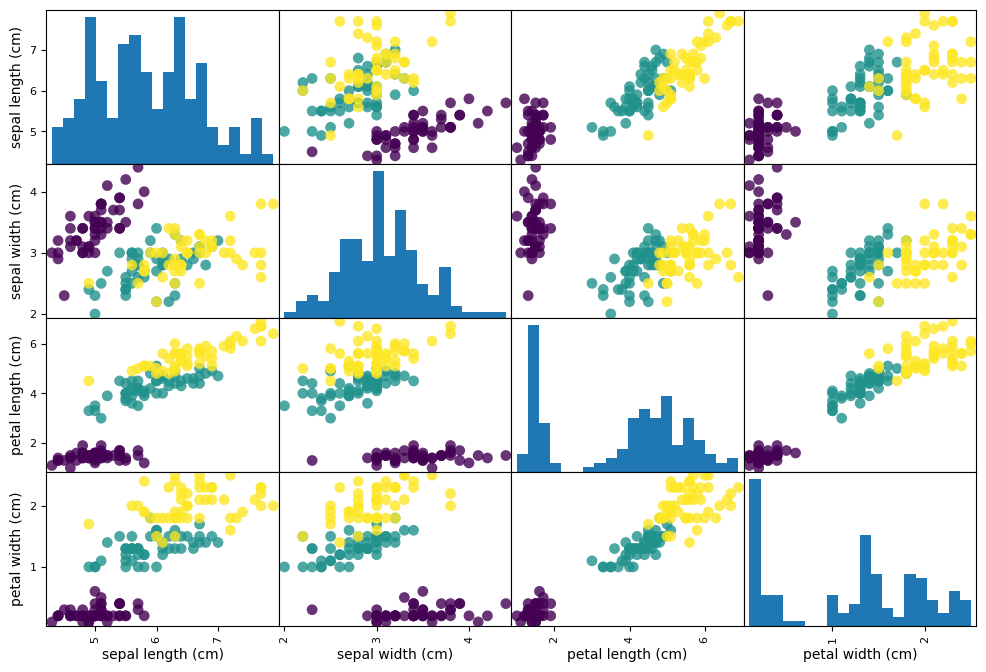

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Cargar el dataset Iris
iris = load_iris()
data = iris.data
target = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Convertir a DataFrame para mejor visualización
df = pd.DataFrame(data, columns=feature_names)
df['target'] = target
df['target'] = df['target'].apply(lambda x: target_names[x])
df.head()

# Visualizar la distribución de las características
pd.plotting.scatter_matrix(df, figsize=(12, 8), c=target, marker='o', hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()


### Limpieza de Datos

In [6]:
# Eliminar outliers y valores vacíos
from scipy import stats

# Eliminar outliers
z_scores = np.abs(stats.zscore(df[feature_names]))
df = df[(z_scores < 3).all(axis=1)]

# Verificar valores vacíos
df.isnull().sum()


,0
sepal length (cm),0
sepal width (cm),0
petal length (cm),0
petal width (cm),0
target,0


### Selección de Características

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

# Seleccionar las mejores características
X = df[feature_names].values
y = df['target'].values
selector = SelectKBest(score_func=f_classif, k=2)
X_new = selector.fit_transform(X, y)
selected_features = np.array(feature_names)[selector.get_support()]
print("Características seleccionadas: ", selected_features)


Características seleccionadas:  ['petal length (cm)' 'petal width (cm)']


### División de los Conjuntos en Entrenamiento, Prueba y Validación

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch

# Codificar las etiquetas como valores numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir el dataset en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_new, y_encoded, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convertir a tensores
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Crear dataloaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Definición del Modelo

In [9]:
# Definir el modelo
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = IrisModel()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Entrenamiento del Modelo

In [10]:
# Entrenar el modelo
num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch [10/50], Train Loss: 0.1411, Val Loss: 0.2048
Epoch [20/50], Train Loss: 0.0532, Val Loss: 0.2288
Epoch [30/50], Train Loss: 0.0335, Val Loss: 0.3195
Epoch [40/50], Train Loss: 0.0289, Val Loss: 0.3486
Epoch [50/50], Train Loss: 0.0270, Val Loss: 0.5069


### Evaluación del Modelo

Test accuracy: 86.66666666666667%
Matriz de confusión:
 [[10  0  0]
 [ 0  5  4]
 [ 0  0 11]]
Reporte de clasificación:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.56      0.71         9
   virginica       0.73      1.00      0.85        11

    accuracy                           0.87        30
   macro avg       0.91      0.85      0.85        30
weighted avg       0.90      0.87      0.86        30



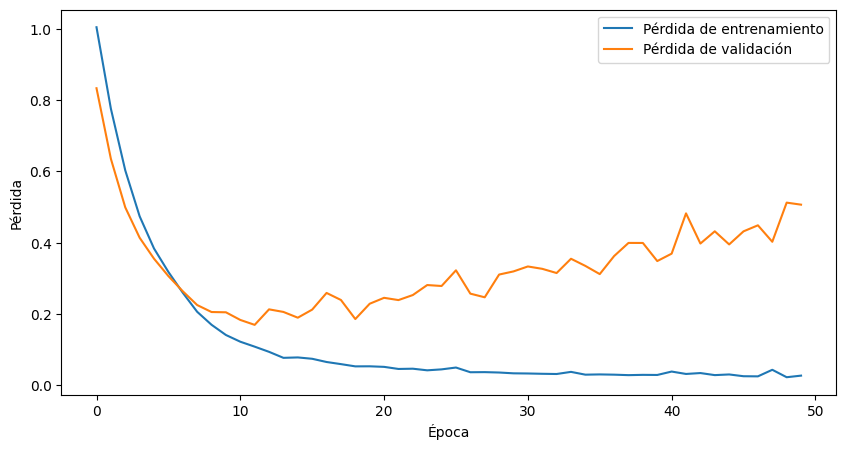

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluar el modelo
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())
print(f'Test accuracy: {100 * correct / total}%')

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", conf_matrix)

# Reporte de clasificación
class_report = classification_report(all_labels, all_preds, target_names=target_names)
print("Reporte de clasificación:\n", class_report)

# Graficar curvas de pérdida
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


## 2. Regresión con el dataset de viviendas de California

### Carga y Visualización de los Datos

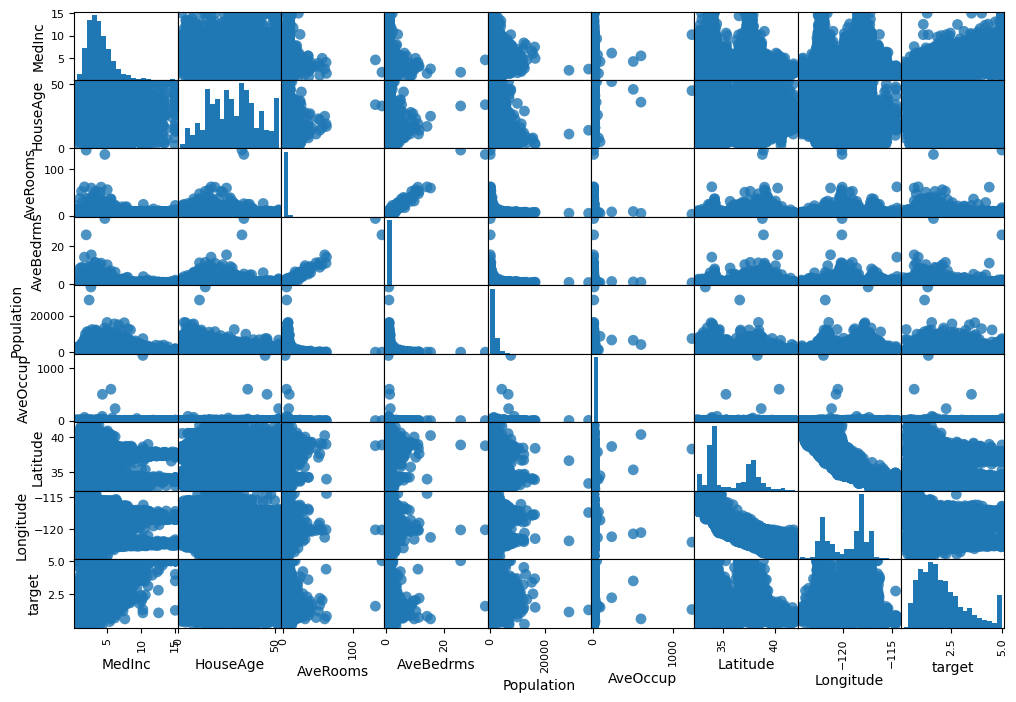

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# Cargar el dataset de viviendas de California
california = fetch_california_housing()
data = california.data
target = california.target
feature_names = california.feature_names

# Convertir a DataFrame para mejor visualización
df = pd.DataFrame(data, columns=feature_names)
df['target'] = target
df.head()

# Visualizar la distribución de las características
pd.plotting.scatter_matrix(df, figsize=(12, 8), marker='o', hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()


### Limpieza de Datos

In [13]:
# Eliminar outliers y valores vacíos
from scipy import stats

# Eliminar outliers
z_scores = np.abs(stats.zscore(df[feature_names]))
df = df[(z_scores < 3).all(axis=1)]

# Verificar valores vacíos
df.isnull().sum()


,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
target,0


### Selección de Características

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression

# Seleccionar las mejores características
X = df[feature_names].values
y = df['target'].values
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)
selected_features = np.array(feature_names)[selector.get_support()]
print("Características seleccionadas: ", selected_features)


Características seleccionadas:  ['MedInc' 'HouseAge' 'AveRooms' 'AveOccup' 'Latitude']


### División de los Conjuntos en Entrenamiento, Prueba y Validación

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Dividir el dataset en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convertir a tensores
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Crear dataloaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Definición del Modelo

In [16]:
# Definir el modelo
class CaliforniaModel(nn.Module):
    def __init__(self):
        super(CaliforniaModel, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CaliforniaModel()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### Entrenamiento del Modelo

In [17]:
# Entrenar el modelo
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch [10/100], Train Loss: 0.4046, Val Loss: 0.4272
Epoch [20/100], Train Loss: 0.3867, Val Loss: 0.4080
Epoch [30/100], Train Loss: 0.3858, Val Loss: 0.4652
Epoch [40/100], Train Loss: 0.3789, Val Loss: 0.4122
Epoch [50/100], Train Loss: 0.3774, Val Loss: 0.4054
Epoch [60/100], Train Loss: 0.3759, Val Loss: 0.4090
Epoch [70/100], Train Loss: 0.3796, Val Loss: 0.4469
Epoch [80/100], Train Loss: 0.3752, Val Loss: 0.3986
Epoch [90/100], Train Loss: 0.3708, Val Loss: 0.4055
Epoch [100/100], Train Loss: 0.3733, Val Loss: 0.4075


### Evaluación del Modelo

Test MAE: 0.4531


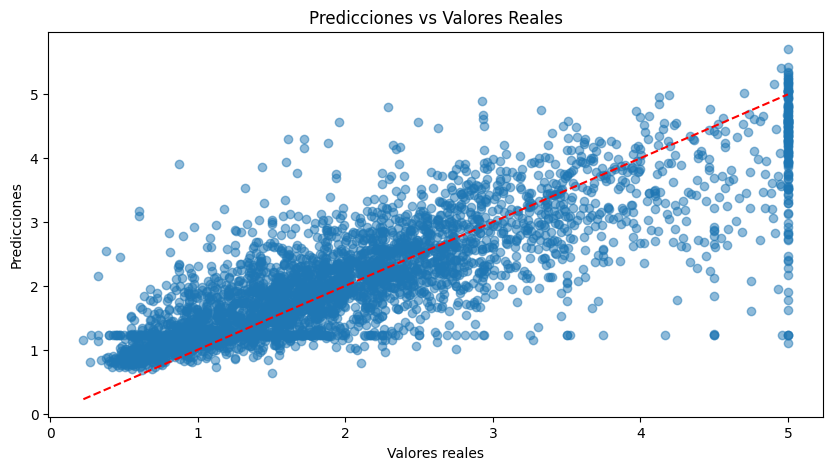

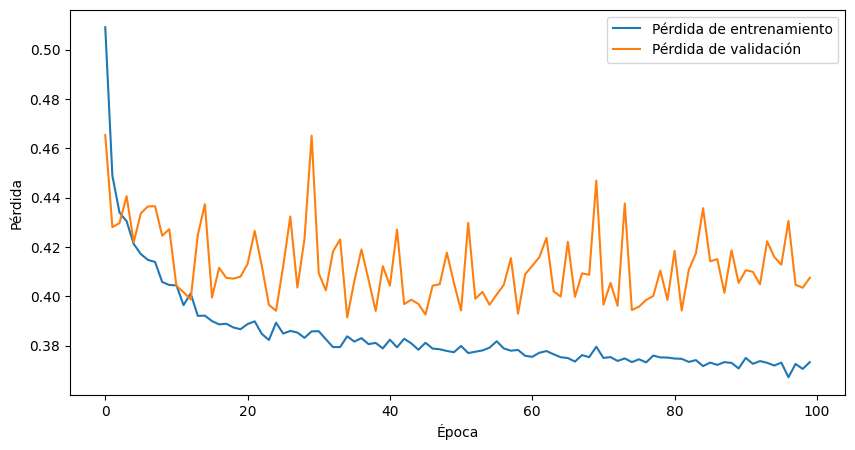

In [18]:
# Evaluar el modelo
model.eval()
mae = 0
preds = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        mae += torch.mean(torch.abs(outputs - targets)).item()
        preds.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())
mae = mae / len(test_loader)
print(f'Test MAE: {mae:.4f}')

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 5))
plt.scatter(actuals, preds, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

# Graficar curvas de pérdida
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
